In [1]:
import pandas as pd
import numpy as np
import copy
import re
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from PIL import Image
from wordcloud import WordCloud
from collections import Counter
pd.options.mode.chained_assignment = None  # 경고 숨기기

# 1. 최종 WordCloud

- 최종 전처리 된 데이터 불러오기

In [5]:
# 최종 전처리 완료된 데이터 불러오기
from google.colab import files

uploaded = files.upload()

news = pd.read_csv('hybe_03.Preprocessing_FIN.csv')

news.head()

Saving hybe_03.Preprocessing_FIN.csv to hybe_03.Preprocessing_FIN.csv


,Date,Title,ppc_Title,Tokens,Stop_tokens
0,2023-06-01,"하이브, 새 걸그룹 선보인다…데뷔 서바이벌 프로그램 론칭",하이브 새 걸그룹 선보인다 데뷔 서바이벌 프로그램 론칭,"['하이브', '걸그룹', '데뷔', '서바이벌', '프로그램', '론칭']",하이브 걸그룹 데뷔 서바이벌 프로그램 론칭
1,2023-06-01,BTS '단체활동 중단' 미리 알고…하이브 직원들 주식매도 적발 [1분뉴스],BTS 단체활동 중단 미리 알고 하이브 직원들 주식매도 적발,"['방탄소년단', '단체', '활동', '중단', '하이브', '직원', '주식',...",방탄소년단 단체 활동 중단 하이브 직원 주식 매도 적발
2,2023-06-01,"미공개정보 이용한 하이브 직원 후회막심?...SM사태 이후 하이브 급등, 카카오 하락",미공개정보 이용한 하이브 직원 후회막심 SM사태 이후 하이브 급등 카카오 하락,"['미공개', '정보', '이용', '하이브', '직원', '후회', '막심', '...",미공개 정보 이용 하이브 직원 후회 막심 사태 이후 하이브 급등 카카오 하락
3,2023-06-01,다 오를 때 혼자 부진했는데…'엑소'와의 갈등에 또 다시 악재 맞은 SM,다 오를 때 혼자 부진했는데 엑소 와의 갈등에 또 다시 악재 맞은 SM,"['때', '부진', '엑소', '와', '갈등', '악재', 'SM']",부진 엑소 갈등 악재 SM
4,2023-06-01,“하이브만이 아니었네”…올해 주식 불공정거래 절반이 '미공개정보 이용',하이브만이 아니었네 올해 주식 불공정거래 절반이 미공개정보 이용,"['하이브', '올해', '주식', '공정', '거래', '절반', '미공개', '...",하이브 주식 공정 거래 절반 미공개 정보 이용


In [6]:
# 각 데이터프레임의 토큰을 하나의 문자열로 변환
news_data = ''
for _, row in news.iterrows():
    news_data += row['Stop_tokens']+ ' '
news_data

"['하이브', '걸그룹', '데뷔', '서바이벌', '프로그램', '론칭'] ['방탄소년단', '단체', '활동', '중단', '하이브', '직원', '주식', '매도', '적발'] ['미공개', '정보', '이용', '하이브', '직원', '후회', '막심', '사태', '이후', '하이브', '급등', '카카오', '하락'] ['때', '부진', '엑소', '와', '갈등', '악재', 'SM'] ['하이브', '올해', '주식', '공정', '거래', '절반', '미공개', '정보', '이용'] ['방탄소년단', '활동', '중단', '시가총액', '조', '증발', '주식', '판', '하이브', '직원'] ['하이브', '적발', '금감원', '이복현', '내부', '정보', '이용', '엄단'] ['엔하이픈', '(여자)아이들', '위', '하이브', '신인', '보이넥스트도어', '데뷔', '엠카'] ['인생네컷', '아이돌', '가능', '하이브', '빅히트', '쏘스뮤직', '인생네컷', '오디션', '개최'] ['하이브', '신인', '보이넥스트도어', '엠카', '서', '음악', '방송', '데뷔'] ['하이브', '서바이벌', '프로그램', '걸그룹'] ['하이브', '금양', '미공시', '정보', '공개', '사례', '속출', '투자자', '곡소리'] ['방탄소년단', '소속사', '직원', '주가', '급락', '매도', '손실', '회피'] ['하이브', 'SM', 'YG', '신인', '그룹', '격돌', '팬덤', '확보', '전략', '가지각색'] ['하이브', '주가', '급등', '방탄소년단', '공백', '우려'] ['초유', '선관위', '특혜', '채용', '비리', '전수', '조사'] ['콘래드', '서울', '방탄소년단', '기념', '하이브', '컬래버레이션', '진행'] ['업황', '부진', '김남국', '불똥', '내우외환', '두나무', '속살'] ['법인', '출자', '개', '사업', '다각'

In [7]:
# 한글 폰트 다운로드 - Noto Sans CJK 폰트 설치
import subprocess
!apt-get update -qq
!apt-get install fonts-noto-cjk -qq

# 설치된 폰트 파일 경로 확인
font_path = subprocess.check_output('fc-list :lang=ko | grep "NotoSansCJK" | head -n 1', shell=True).decode().strip().split(':')[0]
# 한글 폰트 설정
path = f'{font_path}'
fontprop = fm.FontProperties(fname=path, size=12)

Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


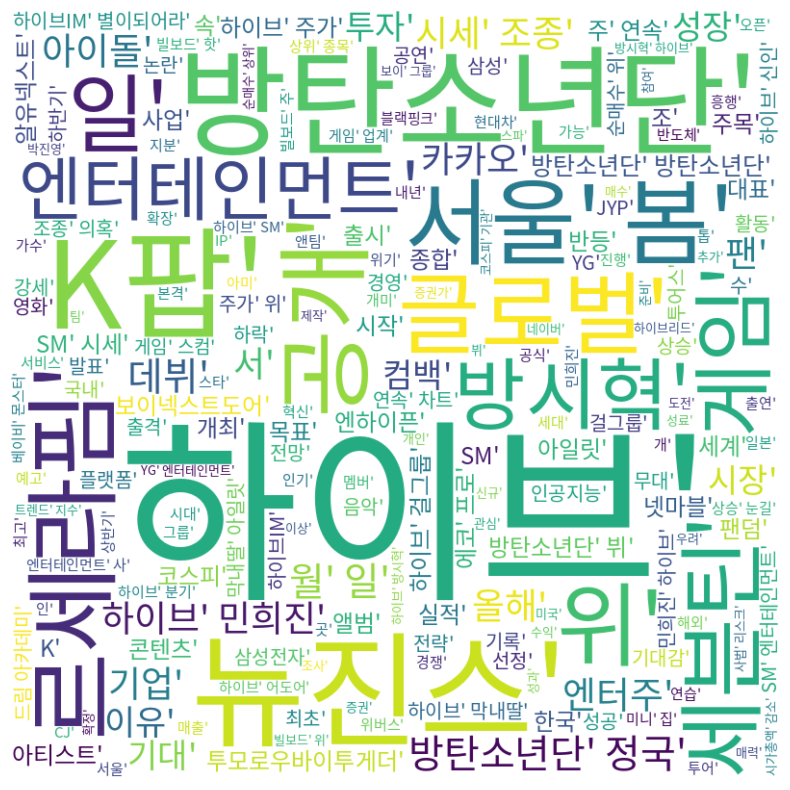

In [8]:
# 워드 클라우드 생성
cloud = WordCloud(font_path= path,
                  background_color='white',
                  width=800, height=800)

# 텍스트 데이터로부터 워드 클라우드 생성
my_cloud1 = cloud.generate(news_data)

# 워드 클라우드를 배열로 변환하고 표시
arr1 = my_cloud1.to_array()

# 워드 클라우드 이미지 표시
fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1, interpolation='bilinear')
plt.axis('off')
plt.show()

# 생성한 그림 저장하기
fig.savefig('wordcloud_hybe_02.png')

# 2. 감정 분석

- 감정 사전 불러오기
(출처: # https://github.com/somijjjjj/BigOne)

In [9]:
# 감정 사전 데이터 불러오기
from google.colab import files

uploaded = files.upload()

word_dict_df = pd.read_csv("단어합본.csv")
word_dict_df = word_dict_df.drop(columns=['Unnamed: 0'])
word_dict = word_dict_df.set_index('word').to_dict()['polarity']

Saving 단어합본.csv to 단어합본.csv


### (1) 감정 사전 기반 계산

In [10]:
news.head()

,Date,Title,ppc_Title,Tokens,Stop_tokens
0,2023-06-01,"하이브, 새 걸그룹 선보인다…데뷔 서바이벌 프로그램 론칭",하이브 새 걸그룹 선보인다 데뷔 서바이벌 프로그램 론칭,"['하이브', '걸그룹', '데뷔', '서바이벌', '프로그램', '론칭']",하이브 걸그룹 데뷔 서바이벌 프로그램 론칭
1,2023-06-01,BTS '단체활동 중단' 미리 알고…하이브 직원들 주식매도 적발 [1분뉴스],BTS 단체활동 중단 미리 알고 하이브 직원들 주식매도 적발,"['방탄소년단', '단체', '활동', '중단', '하이브', '직원', '주식',...",방탄소년단 단체 활동 중단 하이브 직원 주식 매도 적발
2,2023-06-01,"미공개정보 이용한 하이브 직원 후회막심?...SM사태 이후 하이브 급등, 카카오 하락",미공개정보 이용한 하이브 직원 후회막심 SM사태 이후 하이브 급등 카카오 하락,"['미공개', '정보', '이용', '하이브', '직원', '후회', '막심', '...",미공개 정보 이용 하이브 직원 후회 막심 사태 이후 하이브 급등 카카오 하락
3,2023-06-01,다 오를 때 혼자 부진했는데…'엑소'와의 갈등에 또 다시 악재 맞은 SM,다 오를 때 혼자 부진했는데 엑소 와의 갈등에 또 다시 악재 맞은 SM,"['때', '부진', '엑소', '와', '갈등', '악재', 'SM']",부진 엑소 갈등 악재 SM
4,2023-06-01,“하이브만이 아니었네”…올해 주식 불공정거래 절반이 '미공개정보 이용',하이브만이 아니었네 올해 주식 불공정거래 절반이 미공개정보 이용,"['하이브', '올해', '주식', '공정', '거래', '절반', '미공개', '...",하이브 주식 공정 거래 절반 미공개 정보 이용


In [11]:
def find_sentiment_words(tokens, word_dict):
    pos_words = []
    neg_words = []
    zero_words = []
    sentiment_words = []

    total_polarity = 0

    for token in tokens.split():  # 각 단어를 공백 기준으로 분리
        if token in word_dict:
            sentiment_words.append(token)
            if word_dict[token] > 0:
                pos_words.append(token)
                total_polarity += word_dict[token]
            elif word_dict[token] < 0:
                neg_words.append(token)
                total_polarity += word_dict[token]
            else:
                zero_words.append(token)
        else:
            zero_words.append(token)

    return sentiment_words, pos_words, neg_words, zero_words, total_polarity

# 예제 데이터프레임과 word_dict를 사용하여 결과를 계산
sentiment_results = news['Stop_tokens'].apply(lambda x: find_sentiment_words(x, word_dict))

# 결과 출력
sentiment_results


0       ([프로그램], [], [], [하이브, 걸그룹, 데뷔, 서바이벌, 프로그램, 론칭...
1       ([중단, 직원, 주식, 매도, 적발], [], [중단, 매도, 적발], [방탄소년...
2       ([정보, 직원, 후회, 사태, 이후, 급등, 카카오, 하락], [이후, 급등], ...
3          ([부진, 갈등, 악재], [], [부진, 갈등, 악재], [엑소, SM], -4)
4       ([주식, 거래, 절반, 정보], [], [절반], [하이브, 주식, 공정, 거래,...
                              ...                        
9183                      ([], [], [], [이희주, 완벽, 핸섬가], 0)
9184    ([처분], [], [처분], [뉴진스, 앨범, 만장, 민희진, 해임, 이번, 결론...
9185    ([공격, 보호, 표절, 고소], [보호], [공격, 표절, 고소], [민희진, 아...
9186                                ([], [], [], [공승], 0)
9187            ([], [], [], [이성민, 이희주, 공승, 박지화, 웃음꽃], 0)
Name: Stop_tokens, Length: 9188, dtype: object

In [12]:
news['Sentiment_Word'] = sentiment_results.apply(lambda x: ', '.join(x[0]))
news['Pos_Word'] = sentiment_results.apply(lambda x: ', '.join(x[1]))
news['Neg_Word'] = sentiment_results.apply(lambda x: ', '.join(x[2]))
news['Zero_Word'] = sentiment_results.apply(lambda x: ', '.join(x[3]))
news['Score'] = sentiment_results.apply(lambda x: x[4])
news

,Date,Title,ppc_Title,Tokens,Stop_tokens,Sentiment_Word,Pos_Word,Neg_Word,Zero_Word,Score
0,2023-06-01,"하이브, 새 걸그룹 선보인다…데뷔 서바이벌 프로그램 론칭",하이브 새 걸그룹 선보인다 데뷔 서바이벌 프로그램 론칭,"['하이브', '걸그룹', '데뷔', '서바이벌', '프로그램', '론칭']",하이브 걸그룹 데뷔 서바이벌 프로그램 론칭,프로그램,,,"하이브, 걸그룹, 데뷔, 서바이벌, 프로그램, 론칭",0
1,2023-06-01,BTS '단체활동 중단' 미리 알고…하이브 직원들 주식매도 적발 [1분뉴스],BTS 단체활동 중단 미리 알고 하이브 직원들 주식매도 적발,"['방탄소년단', '단체', '활동', '중단', '하이브', '직원', '주식',...",방탄소년단 단체 활동 중단 하이브 직원 주식 매도 적발,"중단, 직원, 주식, 매도, 적발",,"중단, 매도, 적발","방탄소년단, 단체, 활동, 하이브, 직원, 주식",-3
2,2023-06-01,"미공개정보 이용한 하이브 직원 후회막심?...SM사태 이후 하이브 급등, 카카오 하락",미공개정보 이용한 하이브 직원 후회막심 SM사태 이후 하이브 급등 카카오 하락,"['미공개', '정보', '이용', '하이브', '직원', '후회', '막심', '...",미공개 정보 이용 하이브 직원 후회 막심 사태 이후 하이브 급등 카카오 하락,"정보, 직원, 후회, 사태, 이후, 급등, 카카오, 하락","이후, 급등","후회, 사태, 하락","미공개, 정보, 이용, 하이브, 직원, 막심, 하이브, 카카오",-1
3,2023-06-01,다 오를 때 혼자 부진했는데…'엑소'와의 갈등에 또 다시 악재 맞은 SM,다 오를 때 혼자 부진했는데 엑소 와의 갈등에 또 다시 악재 맞은 SM,"['때', '부진', '엑소', '와', '갈등', '악재', 'SM']",부진 엑소 갈등 악재 SM,"부진, 갈등, 악재",,"부진, 갈등, 악재","엑소, SM",-4
4,2023-06-01,“하이브만이 아니었네”…올해 주식 불공정거래 절반이 '미공개정보 이용',하이브만이 아니었네 올해 주식 불공정거래 절반이 미공개정보 이용,"['하이브', '올해', '주식', '공정', '거래', '절반', '미공개', '...",하이브 주식 공정 거래 절반 미공개 정보 이용,"주식, 거래, 절반, 정보",,절반,"하이브, 주식, 공정, 거래, 미공개, 정보, 이용",-1
...,...,...,...,...,...,...,...,...,...,...
9183,2024-05-27,"[MD포토] 이희준, '완벽한 핸섬가이'",이희준 완벽한 핸섬가이,"['이희주', '완벽', '핸섬가']",이희주 완벽 핸섬가,,,,"이희주, 완벽, 핸섬가",0
9184,2024-05-27,뉴진스 앨범 첫날 81만장…민희진 해임 가처분 이번주 결론,뉴진스 앨범 첫날 만장 민희진 해임 가처분 이번주 결론,"['뉴진스', '앨범', '첫날', '만장', '민희진', '해임', '처분', '...",뉴진스 앨범 만장 민희진 해임 처분 이번 결론,처분,,처분,"뉴진스, 앨범, 만장, 민희진, 해임, 이번, 결론",-1
9185,2024-05-27,"민희진 공격 vs 아일릿 보호…‘뉴진스 표절’ 둔 고소전, 어떻게 봐야할까 [D:이슈]",민희진 공격 VS 아일릿 보호 뉴진스 표절 둔 고소전 어떻게 봐야할까,"['민희진', '공격', '아일릿', '보호', '뉴진스', '표절', '고소', ...",민희진 공격 아일릿 보호 뉴진스 표절 고소,"공격, 보호, 표절, 고소",보호,"공격, 표절, 고소","민희진, 아일릿, 뉴진스",-2
9186,2024-05-27,"[MD포토] 공승연, '정말 재밌어요~'",공승연 정말 재밌어요,['공승'],공승,,,,공승,0


In [25]:
# CSV 파일로 저장
news.to_csv('hybe_04.SentimentWord_01.csv', index=False)
# files.download('hybe_04.SentimentWord_01.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

# 3. 감정 별 WordColud

In [14]:
# # 잘 저장 됐는지 확인
# import pandas as pd
# news_check = pd.read_csv('naver_04.SentimentWord_01.csv')
# news_check.head()

news_check = copy.copy(news)
news_check = news_check[news_check['Score']==0]
news_check

,Date,Title,ppc_Title,Tokens,Stop_tokens,Sentiment_Word,Pos_Word,Neg_Word,Zero_Word,Score
0,2023-06-01,"하이브, 새 걸그룹 선보인다…데뷔 서바이벌 프로그램 론칭",하이브 새 걸그룹 선보인다 데뷔 서바이벌 프로그램 론칭,"['하이브', '걸그룹', '데뷔', '서바이벌', '프로그램', '론칭']",하이브 걸그룹 데뷔 서바이벌 프로그램 론칭,프로그램,,,"하이브, 걸그룹, 데뷔, 서바이벌, 프로그램, 론칭",0
7,2023-06-01,"엔하이픈, (여자)아이들 꺾고 1위…'하이브 신인' 보이넥스트도어 데뷔 (엠카)[종합]",엔하이픈 (여자)아이들 꺾고 위 하이브 신인 보이넥스트도어 데뷔 엠카,"['엔하이픈', '(여자)아이들', '위', '하이브', '신인', '보이넥스트도어...",엔하이픈 (여자)아이들 하이브 신인 보이넥스트도어 데뷔 엠카,,,,"엔하이픈, (여자)아이들, 하이브, 신인, 보이넥스트도어, 데뷔, 엠카",0
9,2023-06-01,"'하이브 신인' 보이넥스트도어, '엠카'서 음악방송 데뷔",하이브 신인 보이넥스트도어 엠카 서 음악방송 데뷔,"['하이브', '신인', '보이넥스트도어', '엠카', '서', '음악', '방송'...",하이브 신인 보이넥스트도어 엠카 음악 방송 데뷔,방송,,,"하이브, 신인, 보이넥스트도어, 엠카, 음악, 방송, 데뷔",0
10,2023-06-01,"하이브, 서바이벌 프로그램 통해 새 걸그룹 뽑는다",하이브 서바이벌 프로그램 통해 새 걸그룹 뽑는다,"['하이브', '서바이벌', '프로그램', '걸그룹']",하이브 서바이벌 프로그램 걸그룹,프로그램,,,"하이브, 서바이벌, 프로그램, 걸그룹",0
13,2023-06-01,"하이브, SM, YG 신인 그룹 격돌… 팬덤 확보 전략 가지각색",하이브 SM YG 신인 그룹 격돌 팬덤 확보 전략 가지각색,"['하이브', 'SM', 'YG', '신인', '그룹', '격돌', '팬덤', '확...",하이브 SM YG 신인 그룹 격돌 팬덤 확보 전략 가지각색,"격돌, 확보",확보,격돌,"하이브, SM, YG, 신인, 그룹, 팬덤, 전략, 가지각색",0
...,...,...,...,...,...,...,...,...,...,...
9181,2024-05-27,[Opinion] 가깝고도 먼 엔터 브랜딩 [문화 전반],가깝고도 먼 엔터 브랜딩,"['엔터테인먼트', '브', '랜딩']",엔터테인먼트 브 랜딩,,,,"엔터테인먼트, 브, 랜딩",0
9182,2024-05-27,"에스파 ""컴백 전 이슈? '첫 정규가 잘 되려나 보다' 생각""",에스파 컴백 전 이슈 첫 정규가 잘 되려나 보다 생각,"['스파', '컴백', '이슈', '정규', '생각']",스파 컴백 이슈 정규 생각,"이슈, 생각",,,"스파, 컴백, 이슈, 정규, 생각",0
9183,2024-05-27,"[MD포토] 이희준, '완벽한 핸섬가이'",이희준 완벽한 핸섬가이,"['이희주', '완벽', '핸섬가']",이희주 완벽 핸섬가,,,,"이희주, 완벽, 핸섬가",0
9186,2024-05-27,"[MD포토] 공승연, '정말 재밌어요~'",공승연 정말 재밌어요,['공승'],공승,,,,공승,0


### (1) Pos_Word WordCloud

In [15]:
pos_data = ''
for _, row in news_check.iterrows():
    if isinstance(row['Pos_Word'], str):  # Nan 인 경우 제외하고, 하나의 텍스트로 합치기 (오류 발생하므로)
        pos_data += row['Pos_Word'].replace(',', '') + ' '  # ','를 빈 문자열로 대체하고 단어 사이에 공백 추가
pos_data

'    확보     개최  주목     상승  순매수  투자   최애 회복  매수  미래             장기              성장 협력      열기  도전   목표  순매수              인기 강세                            시작                   제공                          최고              진화 출시                  안전                 기대감                        플러스    회복         상승   상승              순매수                    기회 기대 상승 순매수           매수 진화      질주 진입     투자         견인      시작                       주목                   추가 추가    상승          제공  열정          강세  순매수            호재               급등      순매수      출시  최고    획득 보호  순매수               편의 획득 획득 획득    보호   시작   이후               확장    인기            최고      최고         상승           증가   상승 고백         확장   상승       진화            인기          도약      순매수   덕 확보      복구                          급증   확장  상승    친환경     주목      확장  메타버스         친환경     연속 순매수      활약 상승    매수 연속 우량                    가속         투자     개막                  정조준   제공               확대 순매수 확장       단독      집중 매수 대상 가속     진출  입점

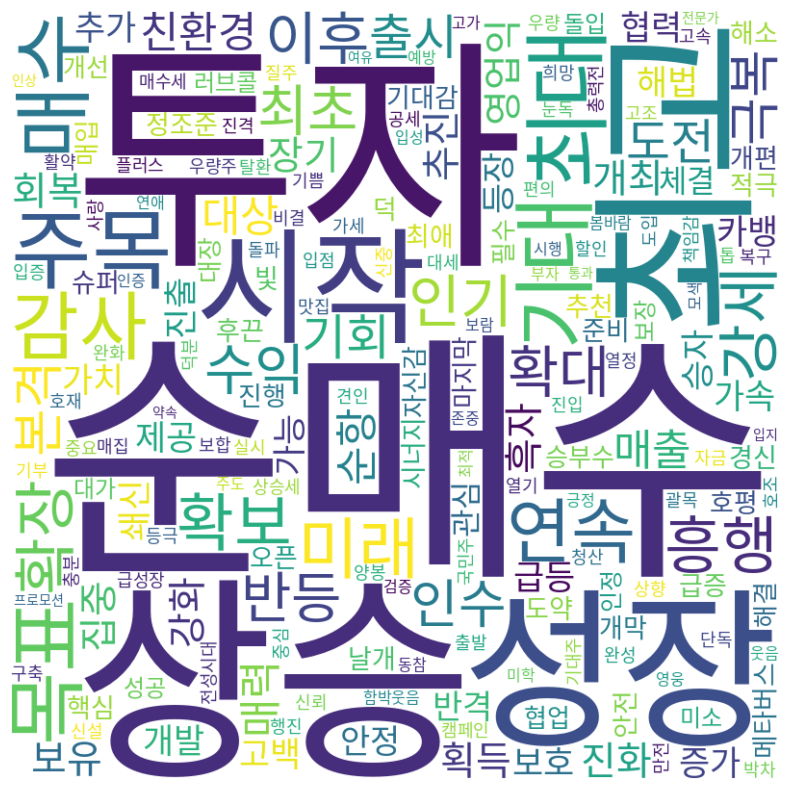

In [16]:
# 워드 클라우드 생성
cloud = WordCloud(font_path= path,
                  background_color='white',
                  width=800, height=800)

# 텍스트 데이터로부터 워드 클라우드 생성
my_cloud1 = cloud.generate(pos_data)

# 워드 클라우드를 배열로 변환하고 표시
arr1 = my_cloud1.to_array()

# 워드 클라우드 이미지 표시
fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1, interpolation='bilinear')
plt.axis('off')
plt.show()

# 생성한 그림 저장하기
fig.savefig('wordcloud_pos.png')

In [17]:
# Colab에서 파일 다운로드
from google.colab import files
files.download('wordcloud_pos.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### (2) Neg_Word WordCloud


In [18]:
neg_data = ''
for _, row in news_check.iterrows():
    if isinstance(row['Neg_Word'], str):  # Nan 인 경우 제외하고, 하나의 텍스트로 합치기 (오류 발생하므로)
        neg_data += row['Neg_Word'].replace(',', '') + ' '  # ','를 빈 문자열로 대체하고 단어 사이에 공백 추가
neg_data

'    격돌     방구석  역대     낙폭  중단  절반   버블 마감  매도  분쟁             역대              고민 논의      뒷걸음  눈물   악재  매도              상한                            겨냥                   혼잡                          역대              독                  환자 비상                 폭발                        한숨    역대         제한   마감              매도                    고민 매도 우려 제한           매도 옛날      분노     마이너스         유료      갈등                       쓴맛                   조치 필요    하락          공격  폭발          하락  약세            시큰둥               논란 하락      매도      투기  평가    평가 논란  매도               연기 평가 평가 평가    과도   탈락   탈               강력    종료            역대      역대         하락           문제   낙폭 후회         공격   하락       버블            역대          비상      하락   루머 탈 철퇴      합의                          환자   격차  낙폭    외면     붕괴      논란  우후죽순         적자     매도 후퇴      상한    저가 하락 끈                    덩치         평가     방구석                  금감원   위기               우려 하락 의혹       압수      급락 착취 하락     감독  아이        정리     평가

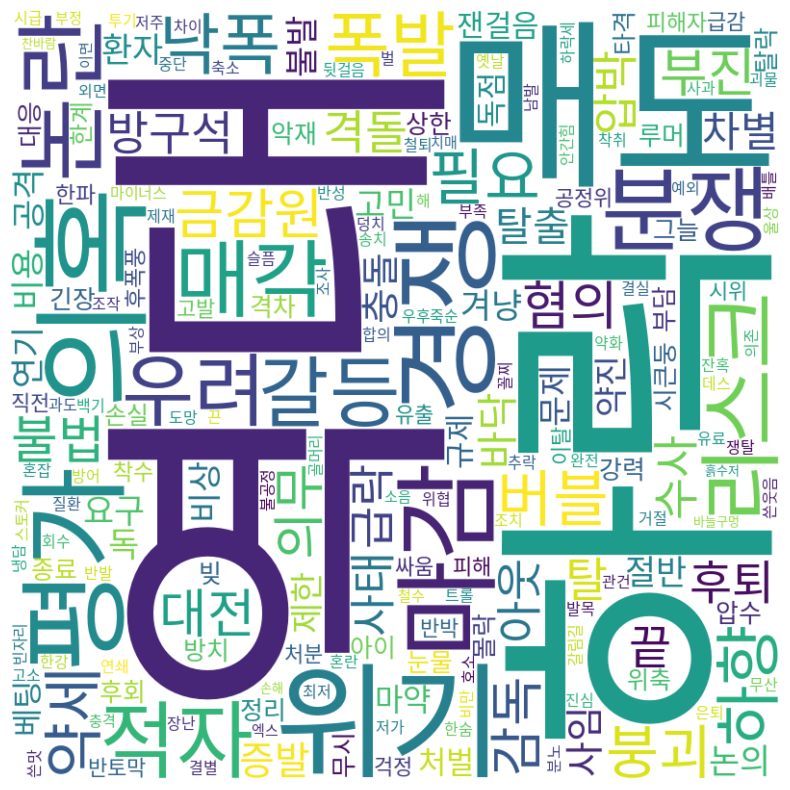

In [19]:
# 워드 클라우드 생성
cloud = WordCloud(font_path= path,
                  background_color='white',
                  width=800, height=800)

# 텍스트 데이터로부터 워드 클라우드 생성
my_cloud1 = cloud.generate(neg_data)

# 워드 클라우드를 배열로 변환하고 표시
arr1 = my_cloud1.to_array()

# 워드 클라우드 이미지 표시
fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1, interpolation='bilinear')
plt.axis('off')
plt.show()

# 생성한 그림 저장하기
fig.savefig('wordcloud_neg.png')

In [20]:
# Colab에서 파일 다운로드
from google.colab import files
files.download('wordcloud_neg.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### (3) Zero_Word WordCloud

In [21]:
zero_data = ''
for _, row in news_check.iterrows():
    if isinstance(row['Zero_Word'], str):  # Nan 인 경우 제외하고, 하나의 텍스트로 합치기 (오류 발생하므로)
        zero_data += row['Zero_Word'].replace(',', '') + ' '  # ','를 빈 문자열로 대체하고 단어 사이에 공백 추가
zero_data

'하이브 걸그룹 데뷔 서바이벌 프로그램 론칭 엔하이픈 (여자)아이들 하이브 신인 보이넥스트도어 데뷔 엠카 하이브 신인 보이넥스트도어 엠카 음악 방송 데뷔 하이브 서바이벌 프로그램 걸그룹 하이브 SM YG 신인 그룹 팬덤 전략 가지각색 오늘 증시 메모 프로미스나인 하이라이트 메들리 영상 공개 음악 호주 아미 방탄소년단 한국 오늘 증시 일정 네오위즈 인디 게임 쇼 하이브 신인 보이넥스트도어 데뷔 무대 하이브 앨범 판매 전망 하반기 플랫폼 사업 아미 방탄소년단 팬 맞이 백화점 면세점 호텔 환호 하이브 알유넥스트 걸그룹 서바이벌 부흥 국민연금 LG 이노텍 하이브 지분 보이넥스트도어 데뷔 출근 하이브 막내 뮤직뱅크 출근길 하이브 공매도 하이브 막내 출근길 운동장 개미 봉 방탄소년단 하이브 주식 하이브 막내 방탄소년단 개미 공정 거래 내부 정보 이용 보이넥스트도어 하이브 막내 뮤직뱅크 출근 방탄소년단 데뷔 아미 컬러 서울 메시지 서비스 위버스 DM 코스피 오름세 보이넥스트도어 핫 데뷔 외인 개인 힘 대결 상반기 개인 블랙핑크 YG 엑소 SM 입대 전속 계약 엑소 하이브 신인 보이넥스트도어 데뷔 무대 주차 성료 진해 경제자유구역 두동 지구 첨단 물류 센터 두동 하이브 스퀘어 신축 하이브 합작품 모먼티카 해외 K팝 팬 반응 K 브랜드 해외 소매상 다리 권영식 넷마블 대표 집행 임원 지금 프로미스나인 개화기 프로미스나인 룰 정규 앨범 프로미스나인 서머 퀸 데뷔 정규 프로미스나인 신곡 미나우 귀 이미경 서울 국제 환경 영화제 집행 위원장 환경 영화 세상 변화 방탄소년단 완전체 소식 완주 방탄소년단 성지 하이브 걸그룹 알유넥스트 티저 포스터 공개 하이브 아티스트 방탄소년단 동생 가요 평정 방탄소년단 투모로우바이투게더 롱런 세븐틴 르세라핌 하이브 레이블 빌보드 점령 하이브 세대 아이돌 지평 보이넥스트도어 걸그룹 탄생 예고 첨단 물류 중심지 부산 진해 경제자유구역 두동 지구 두동 하이브 스퀘어 물류 센터 두나무 생존 전략 NFT 인공지능 ESG 야당 강하늘 유해진 박해준 캐스팅 확정

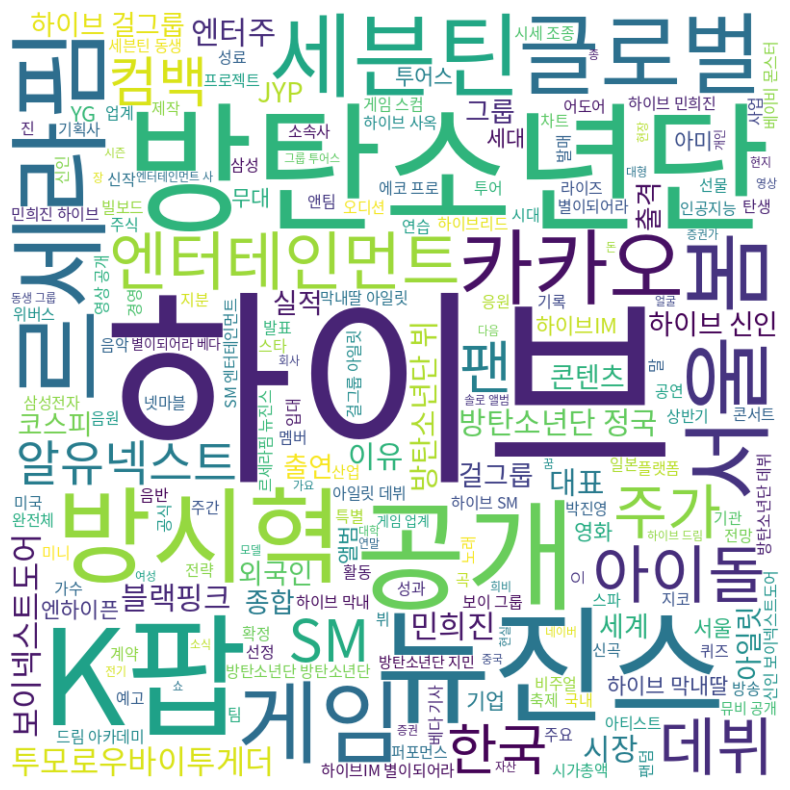

In [22]:
# 워드 클라우드 생성
cloud = WordCloud(font_path= path,
                  background_color='white',
                  width=800, height=800)

# 텍스트 데이터로부터 워드 클라우드 생성
my_cloud1 = cloud.generate(zero_data)

# 워드 클라우드를 배열로 변환하고 표시
arr1 = my_cloud1.to_array()

# 워드 클라우드 이미지 표시
fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1, interpolation='bilinear')
plt.axis('off')
plt.show()

# 생성한 그림 저장하기
fig.savefig('wordcloud_zero.png')

In [23]:
# Colab에서 파일 다운로드
from google.colab import files
files.download('wordcloud_zero.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>